# Male & Female Eyes Classification

![](https://i.pinimg.com/originals/13/9d/a3/139da389d5989f7e854e24e34bffbb1f.jpg)

### Contents
1. Abstract
2. Dataset
3. Goal
4. Importing all the required libraries and dataset
5. Organising Training and testing data
6. Data Distribution
7. Plotting various images
8. Label encoder
9. Neural Network models
    - ConvNet
    - Inception
    - Xception
    - MobileNet
10. Model Comparison
11. Predictions
12. Conclusion

************************
### Abstract
Studies have revealed superior face recognition skills in females, partially due to their different eye movement strategies when encoding faces. In the current project, we utilized these slight but important differences and proposed a model that estimates the gender of the viewers and classifies them into two subgroups, males and females. An eye tracker recorded participant’s eye movements while they viewed images of faces. Regions of interest (ROIs) were defined for each face. Results showed that the gender dissimilarity in eye movements was not due to differences in frequency of fixations in the ROI s per se. Instead, it was caused by dissimilarity in saccade paths between the ROIs. The difference enhanced when saccades were towards the eyes. Females showed significant increase in transitions from other ROI s to the eyes. Consequently, the extraction of temporal transient information of saccade paths through a transition probability matrix, similar to a first order Markov chain model, significantly improved the accuracy of the gender classification results.

### Dataset
The dataset which is used here, is collected from Kaggle website. Here is the link of the dataset : https://www.kaggle.com/pavelbiz/eyes-rtte.

### Goal
The goal of this project is to create a classification model which will classify the genders based on the eyes images as per given in the dataset. For this we are going to use different architectures of Convolution Neural Network.
********************************

### 1. Importing all the required libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

### 2. Organizing Training and Testing Dataframes

In [2]:
# Selecting Dataset Folder Paths
f_dir_ = Path('../input/eyes-rtte/femaleeyes')
m_dir_ = Path('../input/eyes-rtte/maleeyes')
femaleeyes_filepaths = list(f_dir_.glob(r'**/*.jpg'))
maleeyes_filepaths = list(m_dir_.glob(r'**/*.jpg'))

# Mapping the labels
fm_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], femaleeyes_filepaths))
ml_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], maleeyes_filepaths))

# Paths & labels femalee eyes
fm_filepaths = pd.Series(femaleeyes_filepaths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')

# Paths & labels malee eyes
ml_filepaths = pd.Series(maleeyes_filepaths, name = 'File').astype(str)
ml_labels = pd.Series(ml_labels, name='Label')

# Concatenating...
femaleeyes_df = pd.concat([fm_filepaths, fm_labels], axis=1)
maleeyes_df = pd.concat([ml_filepaths, ml_labels], axis=1)

df = pd.concat([femaleeyes_df, maleeyes_df])

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

### 3. Data Distribution

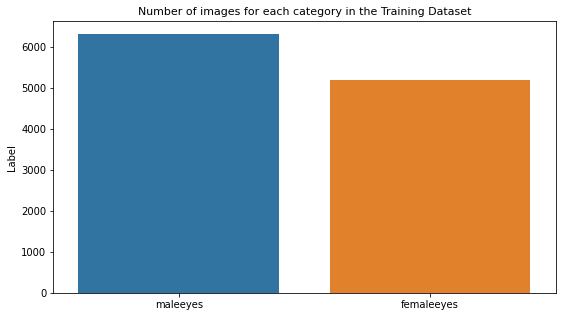

In [3]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

### 4. Observing the images

In [4]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'maleeyes')

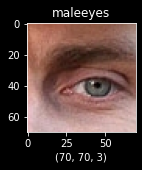

In [5]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'femaleeyes')

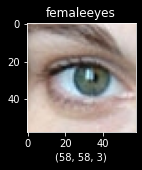

In [6]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][11])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][11])

### 5. Plotting various images from the dataset

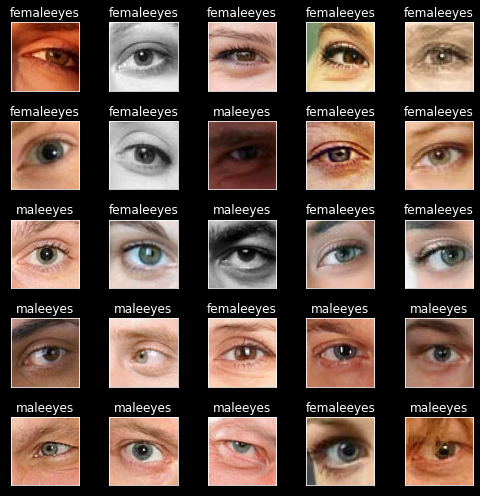

In [7]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

### 6. Dividing into training and testing sets
Now we need to convert our data into training and testing sets. We will use 75% of the images as our training data and test our model on the remaining 25% with Scikit-learn's train_test_split function.

In [8]:
trainset_df, testset_df = train_test_split(df, train_size = 0.75, random_state = 4)

display(trainset_df.head())

testset_df.head()

,File,Label
5614,../input/eyes-rtte/maleeyes/7262.jpg,maleeyes
862,../input/eyes-rtte/femaleeyes/3775.jpg,femaleeyes
9030,../input/eyes-rtte/femaleeyes/128.jpg,femaleeyes
7482,../input/eyes-rtte/maleeyes/889.jpg,maleeyes
5000,../input/eyes-rtte/maleeyes/3309.jpg,maleeyes


,File,Label
3814,../input/eyes-rtte/femaleeyes/6254.jpg,femaleeyes
5238,../input/eyes-rtte/femaleeyes/5784.jpg,femaleeyes
2768,../input/eyes-rtte/femaleeyes/6847.jpg,femaleeyes
2398,../input/eyes-rtte/maleeyes/4254.jpg,maleeyes
9093,../input/eyes-rtte/maleeyes/306.jpg,maleeyes


### 7. Introducing Label Encoder to the dataset

In [9]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [10]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 8643
Number of images with malee eyes: 4729
Number of images with femalee eyes: 3914

Test Dataset:
Number of images: 2882
Number of images with malee eyes: 1594
Number of images with femalee eyes: 1288



### 8. Generating batches of images
In this part we will generate batches of images increasing the training data, for the test database we will just normalize the data using [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)

Parameters of ``ImageDataGenerator``:

    rescale - Transform image size (normalization of data)
    shear_range - Random geometric transformations
    zoom_range - Images that will be zoomed
    rotation_range - Degree of image rotation
    width_shift_range - Image Width Change Range
    height_shift_range - Image height change range
    horizontal_flip - Rotate images horizontally
    vertical_flip - Rotate images vertically
    validation_split - Images that have been reserved for validation (0-1)

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

### 9. Directory of training, validation and test images

Here we make the division of the image bases for training, validation and testing of the model, for that we use the [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method)

Parameters of ``flow_from_directory``:

    dataframe - Dataframe containing the images directory
    x_col - Column name containing the images directory
    y_col - Name of the column containing what we want to predict
    target_size - size of the images (remembering that it must be the same size as the input layer)
    color_mode - RGB color standard
    class_mode - binary class mode (cat/dog)
    batch_size - batch size (32)
    shuffle - Shuffle the data
    seed - optional random seed for the shuffle
    subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)

In [12]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 7779 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 864 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 2882 validated image filenames belonging to 2 classes.
Data generators are ready!


In [13]:
print("Training: ")
print(training_set.class_indices)
print(training_set.image_shape)
print("---" * 8)
print("Validation: ")
print(validation_set.class_indices)
print(validation_set.image_shape)
print("---" * 8)
print("Test: ")
print(test_set.class_indices)
print(test_set.image_shape)

Training: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Validation: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Test: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)


Use of callbacks to monitor models and see if metrics will improve, otherwise training is stopped.

``EarlyStopping`` parameters:

    monitor - Metrics that will be monitored
    patience - Number of times without improvement in the model, after these times the training is stopped
    restore_best_weights - Restores best weights if training is interrupted

In [14]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 15, restore_best_weights = True)]

***********************
## Deployment of Neural Networks
A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature.

A convolutional neural network (CNN) is a type of artificial neural network used in image recognition and processing that is specifically designed to process pixel data. CNN have their “neurons” arranged more like those of the frontal lobe, the area responsible for processing visual stimuli in humans and other animals.

Here we are going to use different architectures of CNN model, they are
1. ConvNet Architecture
2. Inception Architecture
3. MobileNet Architecture
4. Xception Architecture

Let's deploy all of them!
************************

### 1. ConvNet Architecture

CNNs are a specific type of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, that is, that pixels close to each other are often related.

The construction of a CNN begins with specifying the model type. In our case, we will use a ``Sequential`` model.

<p><img src = "https://i.ibb.co/0jWhFsW/ConvNet.png" alt></p>

###### Step 1 - Convolution
Feature Detector and Feature Map

    Number of filters (32)
    Dimensions of the feature detector (3, 3)
    Definition of height / width and RGB channels (128, 128, 3)
    Activation function to remove negative values from the image - 'relu'
    Processing acceleration - BatchNormalization

In [15]:
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), input_shape = (75, 75, 3), activation = 'relu'))
CNN.add(BatchNormalization())

###### Step 2 - Max Pooling
Reduced image size by focusing on the most important features

     Matrix definition with a total of 4 pixels (2, 2)

In [16]:
CNN.add(MaxPooling2D(pool_size = (2, 2)))

###### Step 3 - Hidden Layers

In [17]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [18]:
CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.2))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

###### Step 4 - Flattening
    
     Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [19]:
CNN.add(Flatten())

###### Step 5 - Dense Neural Networks

Parameters of the `` RNA``:

     Dense - All neurons connected
     units - Number of neurons that are part of the hidden layer
     activation - Activation function that will be inserted
     Dropout - is used to decrease the chance of overfitting (20% of the input neurons are zeroed)

Parameters of the ``EarlyStopping``:

     monitor - Metric to be monitored
     patience - Number of seasons without improvement in the model, after the training is interrupted
     restore_best_weights - Restores the best weights if training is interrupted

In [20]:
# Input layer
CNN.add(Dense(units = 128, activation = 'relu'))
CNN.add(Dropout(0.2))
# Output layer (binary classification)
CNN.add(Dense(units = 1, activation = 'sigmoid'))

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 15, 15, 64)        0

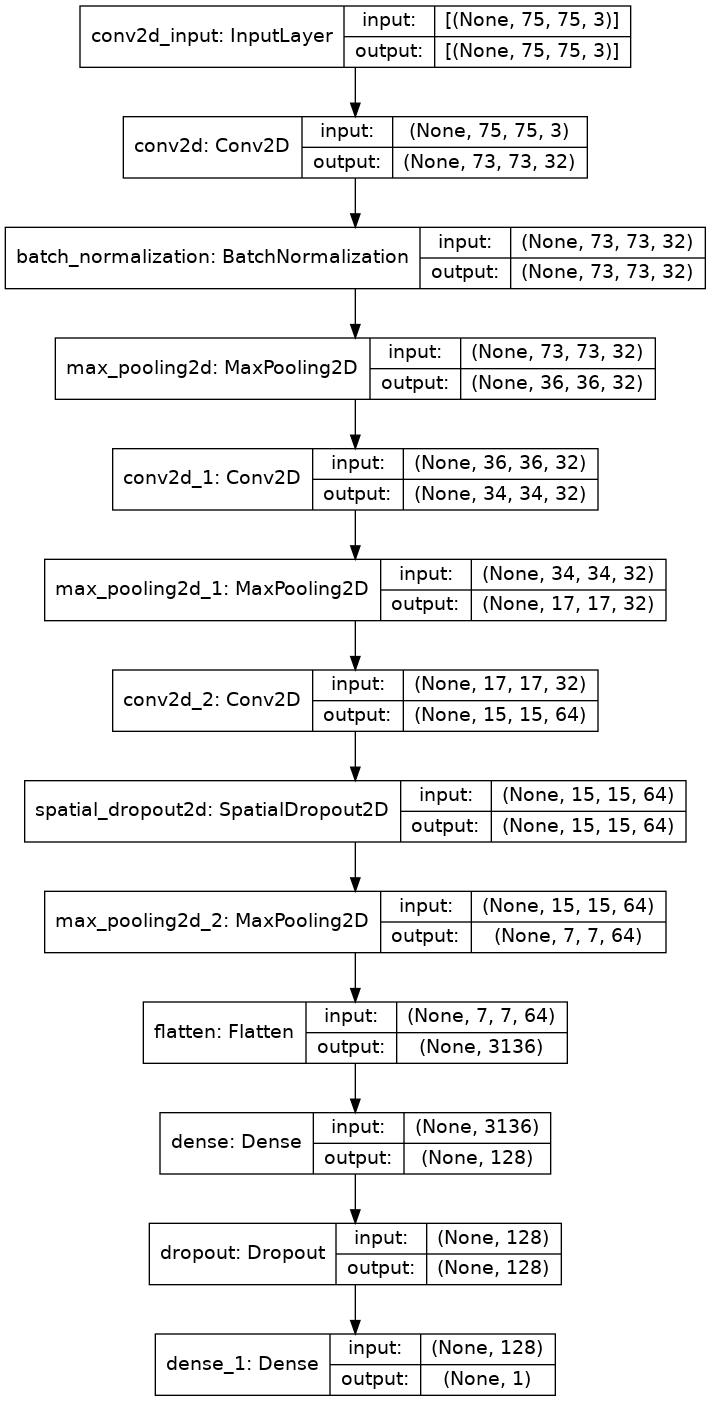

In [21]:
plot_model(CNN, to_file='CNN_model.png', show_layer_names = True , show_shapes = True)

###### Step 6 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [22]:
# Compile
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time...
start = dt.datetime.now()

# Train
CNN_model = CNN.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of counting time...
end = dt.datetime.now()
time_CNN = end - start
print ('\nTraining and validation time is: ', time_CNN)

Epoch 1/50
244/244 [==============================] - 22s 86ms/step - loss: 0.6716 - accuracy: 0.6179 - val_loss: 0.6234 - val_accuracy: 0.6400
Epoch 2/50
244/244 [==============================] - 20s 82ms/step - loss: 0.5645 - accuracy: 0.7143 - val_loss: 0.5093 - val_accuracy: 0.7731
Epoch 3/50
244/244 [==============================] - 20s 82ms/step - loss: 0.4646 - accuracy: 0.7777 - val_loss: 0.4466 - val_accuracy: 0.7940
Epoch 4/50
244/244 [==============================] - 20s 83ms/step - loss: 0.4450 - accuracy: 0.7919 - val_loss: 0.4174 - val_accuracy: 0.8079
Epoch 5/50
244/244 [==============================] - 20s 82ms/step - loss: 0.4024 - accuracy: 0.8197 - val_loss: 0.4901 - val_accuracy: 0.7755
Epoch 6/50
244/244 [==============================] - 20s 81ms/step - loss: 0.4003 - accuracy: 0.8214 - val_loss: 0.3872 - val_accuracy: 0.8264
Epoch 7/50
244/244 [==============================] - 20s 82ms/step - loss: 0.3707 - accuracy: 0.8388 - val_loss: 0.3967 - val_accuracy:

###### Step 7 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

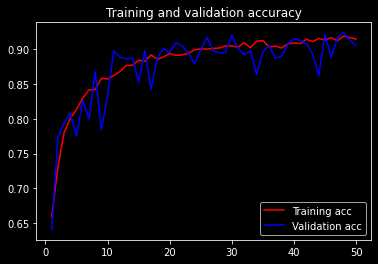

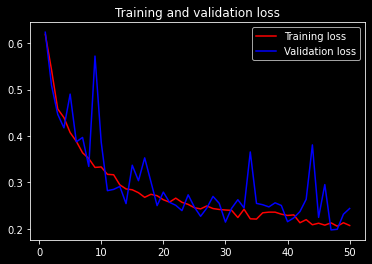

In [23]:
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [24]:
score_CNN = CNN.evaluate(test_set)
print("Test Loss:", score_CNN[0])
print("Test Accuracy:", score_CNN[1])

91/91 [==============================] - 3s 28ms/step - loss: 0.1848 - accuracy: 0.9254
Test Loss: 0.18481937050819397
Test Accuracy: 0.9253990054130554


In [25]:
y_pred_CNN = CNN.predict(test_set)
y_pred_CNN = np.round(y_pred_CNN)

recall_CNN = recall_score(y_test, y_pred_CNN)
precision_CNN = precision_score(y_test, y_pred_CNN)
f1_CNN = f1_score(y_test, y_pred_CNN)
roc_CNN = roc_auc_score(y_test, y_pred_CNN)

In [26]:
print(classification_report(y_test, y_pred_CNN))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1288
           1       0.90      0.97      0.94      1594

    accuracy                           0.93      2882
   macro avg       0.93      0.92      0.92      2882
weighted avg       0.93      0.93      0.92      2882



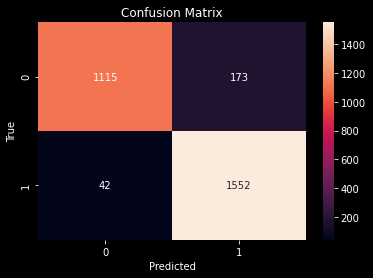

In [27]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_CNN),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

************************
### 2. Inception Architecture
The [InceptionV3](https://keras.io/api/applications/inceptionv3/) model proposed by Szegedy et al. (2015), is a CNN architecture that seeks to solve several large-scale image recognition problems and can also be used in transfer learning problems. Its differential is the presence of convolutional characteristics extractor modules. These modules have the functionality to learn with fewer parameters that contain a greater range of information.

<p><img src = "https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png?hl=pt-br" alt></p>

###### Step 1 - Base model creation
    input_shape - Setting the height/width and RGB channels (128, 128, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [29]:
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

In [30]:
for layer in CNN_base_inc.layers:
    layer.trainable = False

###### Step 2 - Flattening
    Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [31]:
x = layers.Flatten()(CNN_base_inc.output)

###### Step 3 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [32]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)

###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [33]:
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

Epoch 1/50
244/244 [==============================] - 26s 90ms/step - loss: 0.5804 - accuracy: 0.6913 - val_loss: 0.4662 - val_accuracy: 0.7824
Epoch 2/50
244/244 [==============================] - 21s 85ms/step - loss: 0.4684 - accuracy: 0.7780 - val_loss: 0.4639 - val_accuracy: 0.8056
Epoch 3/50
244/244 [==============================] - 21s 85ms/step - loss: 0.4506 - accuracy: 0.7955 - val_loss: 0.4382 - val_accuracy: 0.8079
Epoch 4/50
244/244 [==============================] - 20s 83ms/step - loss: 0.4438 - accuracy: 0.7988 - val_loss: 0.4301 - val_accuracy: 0.8102
Epoch 5/50
244/244 [==============================] - 21s 85ms/step - loss: 0.4387 - accuracy: 0.7947 - val_loss: 0.4271 - val_accuracy: 0.8206
Epoch 6/50
244/244 [==============================] - 21s 85ms/step - loss: 0.4197 - accuracy: 0.8065 - val_loss: 0.4059 - val_accuracy: 0.8241
Epoch 7/50
244/244 [==============================] - 20s 82ms/step - loss: 0.4257 - accuracy: 0.8051 - val_loss: 0.4328 - val_accuracy:

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

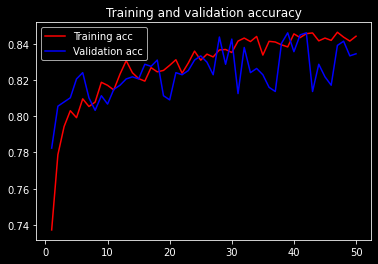

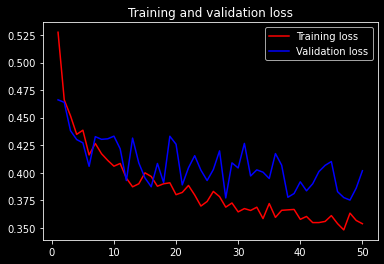

In [34]:
acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 6 - Viewing results and generating forecasts

In [35]:
score_inc = CNN_inc.evaluate(test_set)
print("Test Loss:", score_inc[0])
print("Test Accuracy:", score_inc[1])

91/91 [==============================] - 3s 33ms/step - loss: 0.3304 - accuracy: 0.8553
Test Loss: 0.3303525149822235
Test Accuracy: 0.8553088307380676


In [36]:
y_pred_inc = CNN_inc.predict(test_set)
y_pred_inc = np.round(y_pred_inc)

recall_inc = recall_score(y_test, y_pred_inc)
precision_inc = precision_score(y_test, y_pred_inc)
f1_inc = f1_score(y_test, y_pred_inc)
roc_inc = roc_auc_score(y_test, y_pred_inc)

In [37]:
print(classification_report(y_test, y_pred_inc))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1288
           1       0.87      0.87      0.87      1594

    accuracy                           0.86      2882
   macro avg       0.85      0.85      0.85      2882
weighted avg       0.86      0.86      0.86      2882



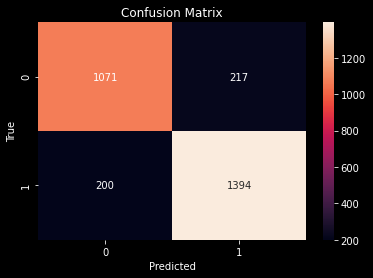

In [38]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_inc),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

*********************************
### 3. Xception Architecture
The [Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception) model proposed by Chollet et al.(2016), is a CNN architecture similar to the Inception described above and, has the difference that the initiation modules were replaced by separable convolutions in depth. Xception has the same amount of parameters as InceptionV3 with a total of 36 convolutional layers. Thus, having a more efficient use of parameters.

<p><img src = "https://miro.medium.com/max/1688/1*J8dborzVBRBupJfvR7YhuA.png" alt></p>

###### Step 1 - Base model creation

    input_shape - Setting the height/width and RGB channels (128, 128, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [40]:
CNN_base_xcep = Xception(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')
CNN_base_xcep.trainable = False

###### Step 2 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [41]:
CNN_xcep = Sequential()
CNN_xcep.add(CNN_base_xcep)
CNN_xcep.add(GlobalAveragePooling2D())
CNN_xcep.add(Dense(128))
CNN_xcep.add(Dropout(0.1))
CNN_xcep.add(Dense(1, activation = 'sigmoid'))

CNN_xcep.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
_________________________________________________________________


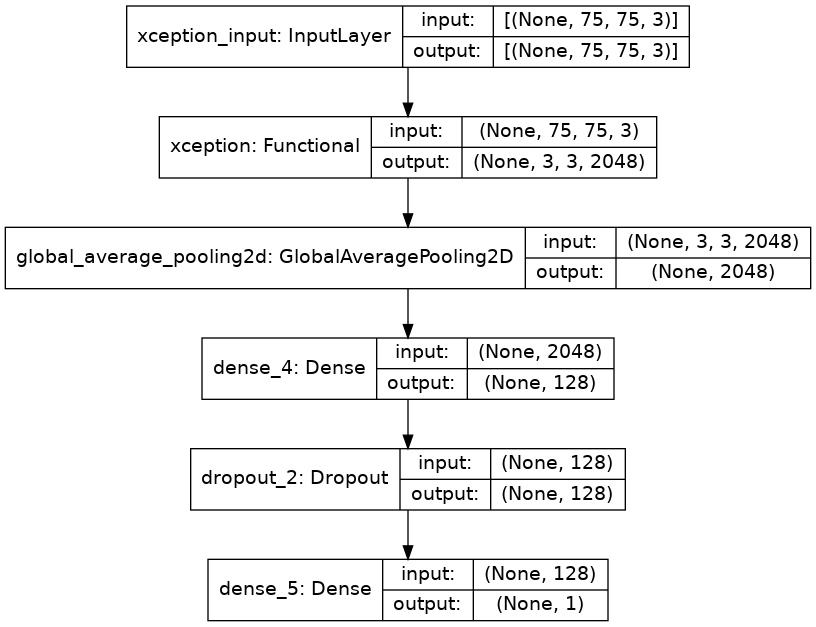

In [42]:
plot_model(CNN_xcep, show_layer_names = True , show_shapes = True)

###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [43]:
# Compilation
CNN_xcep.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_xcep_history = CNN_xcep.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_xcep = end - start
print ('\nTraining and validation time: ', time_CNN_xcep)

Epoch 1/50
244/244 [==============================] - 23s 84ms/step - loss: 0.8354 - accuracy: 0.7276 - val_loss: 0.5943 - val_accuracy: 0.7604
Epoch 2/50
244/244 [==============================] - 20s 83ms/step - loss: 0.4825 - accuracy: 0.7996 - val_loss: 0.4459 - val_accuracy: 0.8102
Epoch 3/50
244/244 [==============================] - 21s 85ms/step - loss: 0.4203 - accuracy: 0.8307 - val_loss: 0.3839 - val_accuracy: 0.8310
Epoch 4/50
244/244 [==============================] - 20s 81ms/step - loss: 0.3928 - accuracy: 0.8350 - val_loss: 0.3862 - val_accuracy: 0.8206
Epoch 5/50
244/244 [==============================] - 20s 83ms/step - loss: 0.3880 - accuracy: 0.8226 - val_loss: 0.4115 - val_accuracy: 0.8160
Epoch 6/50
244/244 [==============================] - 21s 86ms/step - loss: 0.3597 - accuracy: 0.8506 - val_loss: 0.3654 - val_accuracy: 0.8322
Epoch 7/50
244/244 [==============================] - 20s 83ms/step - loss: 0.3652 - accuracy: 0.8482 - val_loss: 0.4218 - val_accuracy:

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

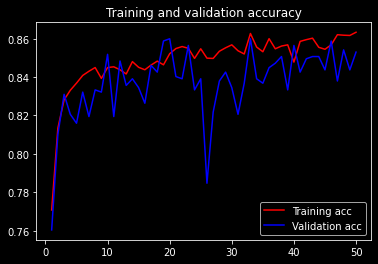

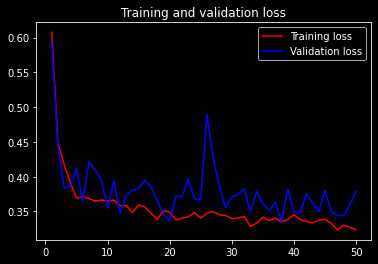

In [44]:
acc = CNN_xcep_history.history['accuracy']
val_acc = CNN_xcep_history.history['val_accuracy']
loss = CNN_xcep_history.history['loss']
val_loss = CNN_xcep_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [45]:
score_xcep = CNN_xcep.evaluate(test_set)
print("Test Loss:", score_xcep[0])
print("Test Accuracy:", score_xcep[1])

91/91 [==============================] - 3s 28ms/step - loss: 0.3259 - accuracy: 0.8685
Test Loss: 0.3259100317955017
Test Accuracy: 0.8684940934181213


In [46]:
y_pred_xcep = CNN_xcep.predict(test_set)
y_pred_xcep = np.round(y_pred_xcep)

recall_xcep = recall_score(y_test, y_pred_xcep)
precision_xcep = precision_score(y_test, y_pred_xcep)
f1_xcep = f1_score(y_test, y_pred_xcep)
roc_xcep = roc_auc_score(y_test, y_pred_xcep)

In [47]:
print(classification_report(y_test, y_pred_xcep))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1288
           1       0.84      0.94      0.89      1594

    accuracy                           0.87      2882
   macro avg       0.88      0.86      0.86      2882
weighted avg       0.87      0.87      0.87      2882



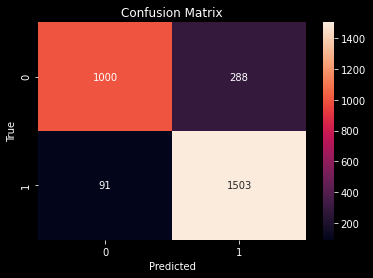

In [48]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_xcep),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

***************************
### 4. MobileNet Architecture
The MobileNet model proposed by Howard et al. (2017), is a CNN architecture that were created to perform computer vision tasks on mobile devices and embedded systems. They are based on in-depth separable convolution operations, which lessens the burden of operations in the first layers.

<p><img src = "https://nitheshsinghsanjay.github.io/images/mobtiny_fig.PNG" alt></p>

###### Step 1 - Base model creation

    input_shape - Setting the height/width and RGB channels (128, 128, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [50]:
CNN_base_mobilenet = MobileNet(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

In [51]:
for layer in CNN_base_mobilenet.layers:
    layer.trainable = False

###### Step 2 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [52]:
CNN_mobilenet = Sequential()
CNN_mobilenet.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet.add(CNN_base_mobilenet)
CNN_mobilenet.add(BatchNormalization())
CNN_mobilenet.add(GlobalAveragePooling2D())
CNN_mobilenet.add(Dropout(0.5))
CNN_mobilenet.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_99 (Batc (None, 75, 75, 3)         12        
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
batch_normalization_100 (Bat (None, 2, 2, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1025      
Total params: 3,233,997
Trainable params: 3,079
Non-trainable params: 3,230,918
________________________________________

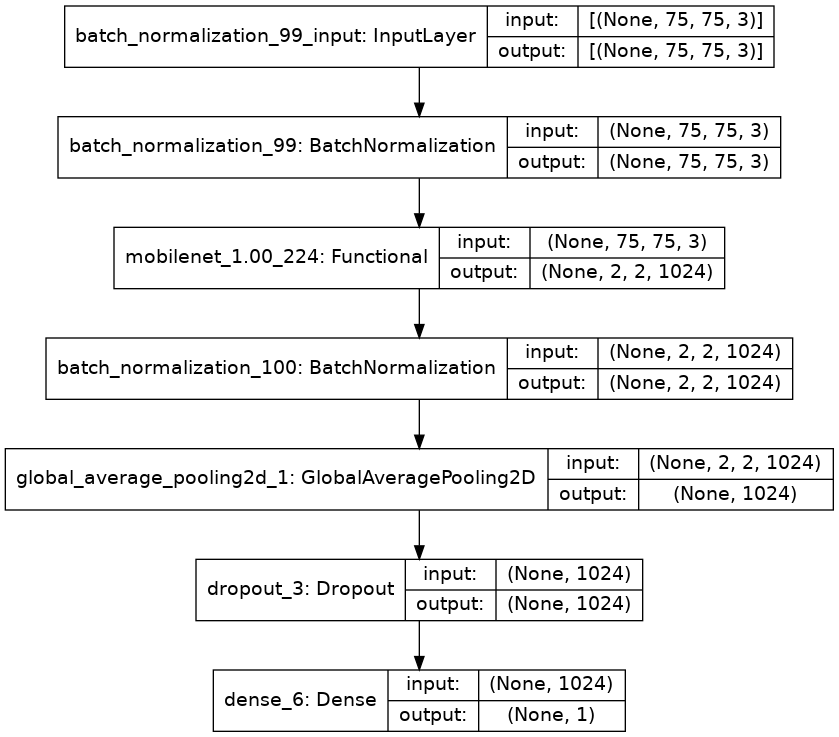

In [53]:
plot_model(CNN_mobilenet, show_layer_names = True , show_shapes = True)

###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [54]:
# Compilation
CNN_mobilenet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_history = CNN_mobilenet.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet)

Epoch 1/50
244/244 [==============================] - 23s 86ms/step - loss: 0.7472 - accuracy: 0.6289 - val_loss: 0.4141 - val_accuracy: 0.8241
Epoch 2/50
244/244 [==============================] - 20s 82ms/step - loss: 0.4955 - accuracy: 0.7695 - val_loss: 0.4066 - val_accuracy: 0.8102
Epoch 3/50
244/244 [==============================] - 20s 83ms/step - loss: 0.4504 - accuracy: 0.7915 - val_loss: 0.3812 - val_accuracy: 0.8218
Epoch 4/50
244/244 [==============================] - 20s 83ms/step - loss: 0.4533 - accuracy: 0.7892 - val_loss: 0.3731 - val_accuracy: 0.8414
Epoch 5/50
244/244 [==============================] - 20s 83ms/step - loss: 0.4534 - accuracy: 0.7866 - val_loss: 0.4067 - val_accuracy: 0.8275
Epoch 6/50
244/244 [==============================] - 21s 84ms/step - loss: 0.4461 - accuracy: 0.8003 - val_loss: 0.3532 - val_accuracy: 0.8495
Epoch 7/50
244/244 [==============================] - 20s 84ms/step - loss: 0.4551 - accuracy: 0.7905 - val_loss: 0.3978 - val_accuracy:

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

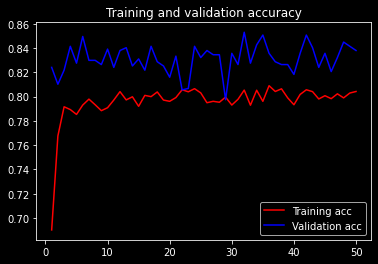

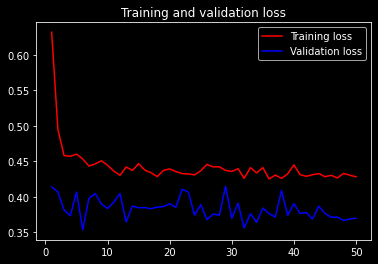

In [55]:
acc = CNN_mobilenet_history.history['accuracy']
val_acc = CNN_mobilenet_history.history['val_accuracy']
loss = CNN_mobilenet_history.history['loss']
val_loss = CNN_mobilenet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [56]:
score_mn = CNN_mobilenet.evaluate(test_set)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

91/91 [==============================] - 2s 26ms/step - loss: 0.3405 - accuracy: 0.8602
Test Loss: 0.3404732346534729
Test Accuracy: 0.8601665496826172


In [57]:
y_pred_mn = CNN_mobilenet.predict(test_set)
y_pred_mn = np.round(y_pred_mn)

recall_mn = recall_score(y_test, y_pred_mn)
precision_mn = precision_score(y_test, y_pred_mn)
f1_mn = f1_score(y_test, y_pred_mn)
roc_mn = roc_auc_score(y_test, y_pred_mn)

In [58]:
print(classification_report(y_test, y_pred_mn))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1288
           1       0.86      0.90      0.88      1594

    accuracy                           0.86      2882
   macro avg       0.86      0.86      0.86      2882
weighted avg       0.86      0.86      0.86      2882



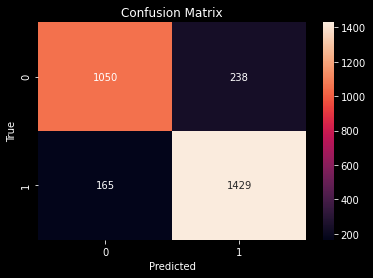

In [59]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

*******************************************
### Model Comparison

In [61]:
models= [('ConvNet', time_CNN, np.mean(CNN_model.history['accuracy']), np.mean(CNN_model.history['val_accuracy'])),
         ('Inception', time_CNN_inc, np.mean(CNN_inc_history.history['accuracy']), np.mean(CNN_inc_history.history['val_accuracy'])),
         ('Xception', time_CNN_xcep, np.mean(CNN_xcep_history.history['accuracy']), np.mean(CNN_xcep_history.history['val_accuracy'])),
         ('MobileNet', time_CNN_mobilenet, np.mean(CNN_mobilenet_history.history['accuracy']), np.mean(CNN_mobilenet_history.history['val_accuracy']))]

df_all_models = pd.DataFrame(models, columns = ['Model', 'Time', 'Training accuracy (%)', 'Validation Accuracy (%)'])

df_all_models

,Model,Time,Training accuracy (%),Validation Accuracy (%)
0,ConvNet,0 days 00:16:25.486987,0.880632,0.875278
1,Inception,0 days 00:17:26.827439,0.827649,0.823704
2,Xception,0 days 00:17:04.962303,0.848770,0.837176
3,MobileNet,0 days 00:17:03.397347,0.795992,0.830995


In [62]:
models = [('ConvNet', score_CNN[1], recall_CNN, precision_CNN, f1_CNN, roc_CNN),
          ('Inception', score_inc[1], recall_inc, precision_inc, f1_inc, roc_inc),
          ('Xception', score_xcep[1], recall_xcep, precision_xcep, f1_xcep, roc_xcep),
          ('MobileNet', score_mn[1], recall_mn, precision_mn, f1_mn, roc_mn)]

df_all_models_testset = pd.DataFrame(models, columns = ['Model', 'Test accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 (%)', 'AUC'])

df_all_models_testset

,Model,Test accuracy (%),Recall (%),Precision (%),F1 (%),AUC
0,ConvNet,0.925399,0.973651,0.899710,0.935221,0.919667
1,Inception,0.855309,0.874529,0.865301,0.869891,0.853026
2,Xception,0.868494,0.942911,0.839196,0.888035,0.859654
3,MobileNet,0.860167,0.896487,0.857229,0.876418,0.855852


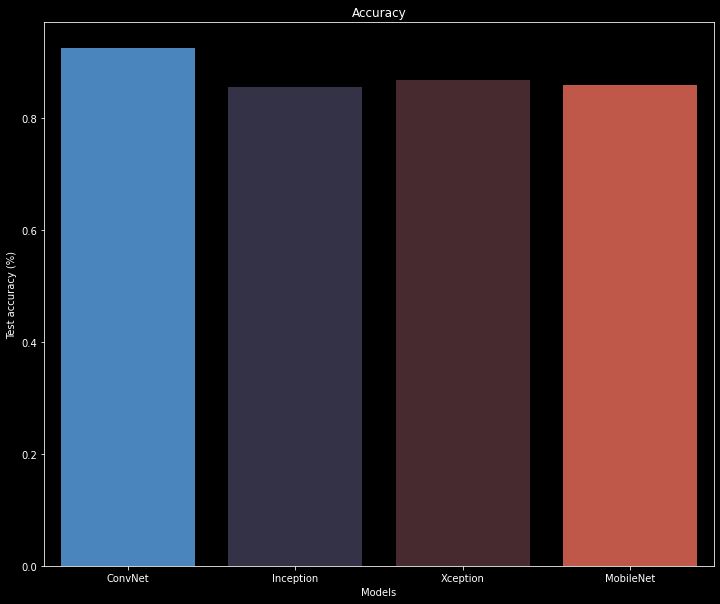

In [63]:
plt.subplots(figsize=(12, 10))
sns.barplot(y = df_all_models_testset['Test accuracy (%)'], x = df_all_models_testset['Model'], palette = 'icefire')
plt.xlabel("Models")
plt.title('Accuracy')
plt.show()

In [64]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_CNN)
fpr_inc, tpr_inc, _ = roc_curve(y_test, y_pred_inc)
fpr_xcep, tpr_xcep, _ = roc_curve(y_test, y_pred_xcep)
fpr_mn, tpr_mn, _ = roc_curve(y_test, y_pred_mn)

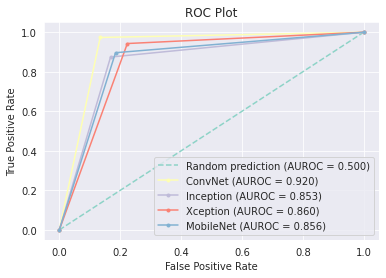

In [65]:
sns.set_style('darkgrid')

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

plt.plot(fpr_cnn, tpr_cnn, marker='.', label='ConvNet (AUROC = %0.3f)' % roc_CNN)
plt.plot(fpr_inc, tpr_inc, marker='.', label='Inception (AUROC = %0.3f)' % roc_inc)
plt.plot(fpr_xcep, tpr_xcep, marker='.', label='Xception (AUROC = %0.3f)' % roc_xcep)
plt.plot(fpr_mn, tpr_mn, marker='.', label='MobileNet (AUROC = %0.3f)' % roc_mn)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

********************************
### Predicting the images with the use of the deployed models

In [66]:
test_set.class_indices

{'femaleeyes': 0, 'maleeyes': 1}

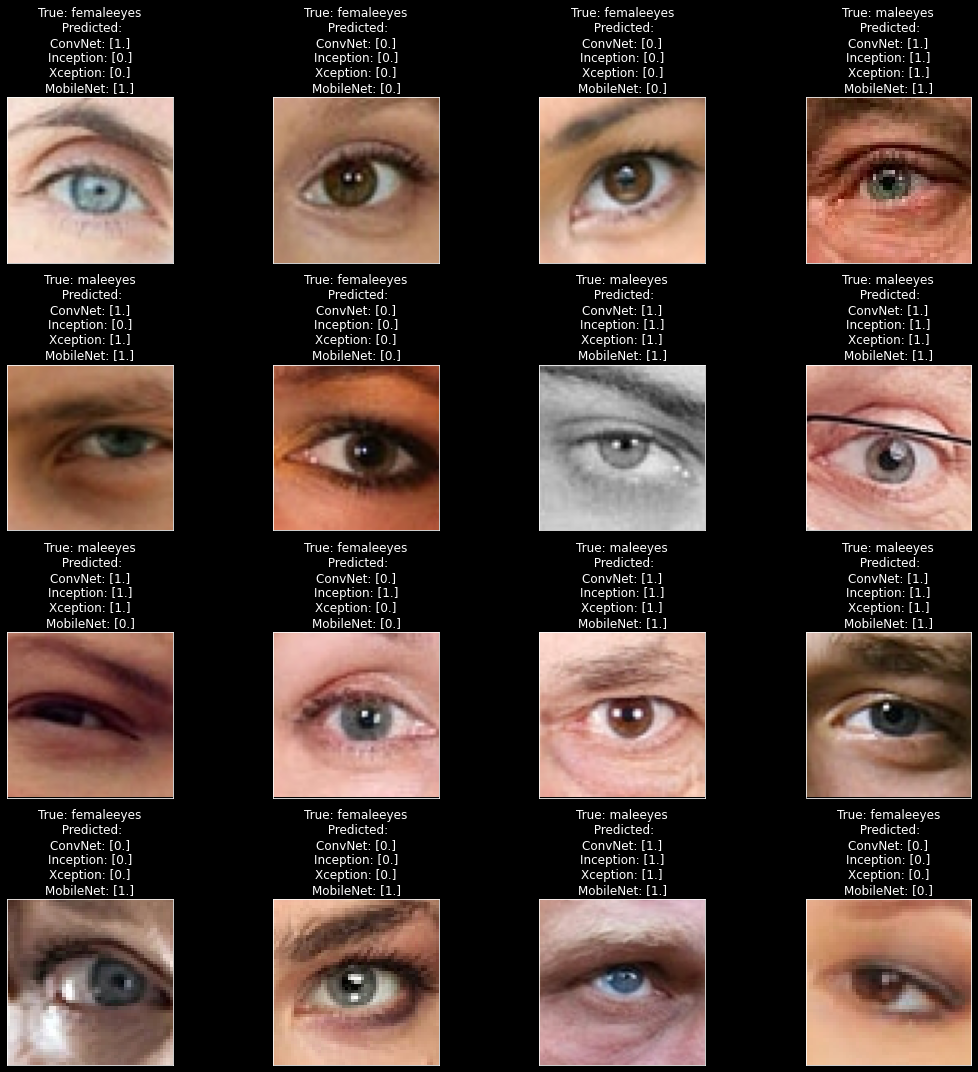

In [67]:
plt.style.use("dark_background")


fig, axes = plt.subplots(nrows = 4,
                         ncols = 4,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    ax.set_title(f"True: {testset_df.Label.iloc[i]}\n Predicted:\nConvNet: {y_pred_CNN[i]}\nInception: {y_pred_inc[i]}\nXception: {y_pred_xcep[i]}\nMobileNet: {y_pred_mn[i]}")
plt.tight_layout()
plt.show()

**************************
## Conclusion
* Images classification is one of the hot topics in today's world.
* Usage of Concolution Neural Network in this type of classification works makes the developer easier to develope models using the architectures.
* Here we have used four different types of architecture, such as, MobileNet, ConvNet, Inception and Xception.
* Among all these deployed models, **ConvNet Architecture** is having the upper hand over all of the rest of the models.
* ***ConvNet Architecture*** is having the accuracy of 0.93, with a F1-score of 0.94 and AUROC value of 0.92, which shows how much the architecture is capable of building the model.
* Hence, **ConvNet is the best fitted Convolution Neural Network architecture used here and deployed successfully!**
***************************************

### Thank You!!